# Project 3 - 02 : Modelization

## Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install requirements
!pip install category_encoders

     |████████████████████████████████| 82 kB 355 kB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# paths
PROJECT_ROOT = '/content/drive/MyDrive/Colab Notebooks/OC_IML/OC_IML_P3_EnergyConsumption'
DATA_DIR = os.path.join(PROJECT_ROOT, 'Pelec_04_data')
MODELS_DIR = os.path.join(DATA_DIR, 'models')
# set project root as working directory
%cd $PROJECT_ROOT

# pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.options.display.max_colwidth = 500

# plotly
plotly_base_params = {
    'template': "plotly_white",
    'title_font': dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
    'font': dict(color='#424242'), 
    'hoverlabel': dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif")
}



/content/drive/MyDrive/Colab Notebooks/OC_IML/OC_IML_P3_EnergyConsumption


In [ ]:
data = pd.read_csv(os.path.join(DATA_DIR, 'cleaned_data.csv'), sep=',',
                   dtype={'councilDistrictCode': 'category'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   buildingType                     1642 non-null   object  
 1   primaryPropertyType              1642 non-null   object  
 2   councilDistrictCode              1642 non-null   category
 3   neighborhood                     1642 non-null   object  
 4   nb_buildings                     1642 non-null   float64 
 5   nb_floors                        1642 non-null   float64 
 6   propertyGFA_total                1642 non-null   int64   
 7   propertyGFA_parking              1642 non-null   int64   
 8   propertyGFABuilding              1642 non-null   int64   
 9   LargestPropertyUseType           1642 non-null   object  
 10  LargestPropertyUseTypeGFA        1632 non-null   float64 
 11  SecondLargestPropertyUseType     1642 non-null   object  
 12  Second

## Preprocessing

In [ ]:
# convert bool feature to numeric
data.consumeGas = data.consumeGas * 1
data.consumeSteam = data.consumeSteam * 1

### Categorical features encoding 

In [ ]:
data = pd.get_dummies(
    data,
    prefix_sep='_', # separator between prefix and category
    dummy_na=False, # if na are used as a category
    columns=None, # if none selet object and category dtypes
    drop_first=False, # drop first column
    dtype=None  # output dtype
)
print(f"{data.shape[0]} rows / {data.shape[1]} cols")

1642 rows / 213 cols


**Feature Scaling**

In [ ]:
data = np.log1p(data)

**TrainSet / TestSet separation**

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.33, shuffle=True)

**X / y separation**

In [ ]:
# to predict CO2 emission
y_train_co2 = train.GHG_emissions_TCO2e
y_test_co2 = test.GHG_emissions_TCO2e
# To predict the energy consumption
y_train_nrg = train.siteEnergyUse_kBtu
y_test_nrg = test.siteEnergyUse_kBtu

X_train = train.drop(columns=['siteEnergyUse_kBtu', 'GHG_emissions_TCO2e'])
X_test = test.drop(columns=['siteEnergyUse_kBtu', 'GHG_emissions_TCO2e'])

### Missing values imputation

I will impute the missing values using the kNN algorithm as it is a robust method for imputation. kNN uses the Euclidean distance, as its means of comparing examples.  
In order for all of the features to be of equal importance when calculating the distance, the features must have the same range of values.

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

# fit on encoded/scaled train set
imputer.fit(X_train)

# transform encoded/scaled train and test sets 
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

## Model building

### Models comparison

**Models to test**

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    #'LinearRegression': linear_model.LinearRegression(fit_intercept=True,n_jobs=-1),
    'Ridge': linear_model.Ridge(random_state=0),
    'Lasso': linear_model.Lasso(random_state=0),
    'RandomForest': RandomForestRegressor(n_jobs=-1, random_state=0),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=0)
}
metrics = ['neg_root_mean_squared_error', 'r2']
cv = 10

In [ ]:
def compare_models_cv(X_train, y, models:dict, cv:int, metrics:list):
    """Returns the mean score of each metrics applied by cross-validation to passed models"""    
    all_scores = []
    for m in models:
        # calculate the model scores for each y
        model = models[m]
        partial_scores = cross_validate(model, X_train, y, 
                                        cv=cv, scoring=metrics, 
                                        return_train_score=True)
        # convert to a dataframe
        partial_scores = pd.DataFrame.from_dict(partial_scores)
        # get mean score for each metrics and pivot the dataframe
        partial_scores = partial_scores.mean().to_frame().T
        # add the model name into the df
        partial_scores['model'] = m
        # add scores to the scoreslist
        all_scores.append(partial_scores)
    # concat all scores into a single df
    all_scores = pd.concat(all_scores, ignore_index=True).set_index('model')
    return all_scores

In [ ]:
co2_mean_scores = compare_models_cv(X_train, y_train_co2, models, cv, metrics)
co2_mean_scores['test_neg_root_mean_squared_error'] = co2_mean_scores['test_neg_root_mean_squared_error'] * -1
co2_mean_scores['train_neg_root_mean_squared_error'] = co2_mean_scores['train_neg_root_mean_squared_error'] * -1
co2_mean_scores

,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
model,,,,,,
Ridge,0.026,0.011,0.770,0.669,0.676,0.761
Lasso,0.013,0.007,1.353,1.351,0.006,0.025
RandomForest,1.315,0.106,0.803,0.298,0.646,0.953
XGBoost,0.401,0.007,0.764,0.590,0.681,0.814


In [ ]:
nrg_mean_scores = compare_models_cv(X_train, y_train_nrg, models, cv, metrics)
nrg_mean_scores['test_neg_root_mean_squared_error'] = nrg_mean_scores['test_neg_root_mean_squared_error'] * -1
nrg_mean_scores['train_neg_root_mean_squared_error'] = nrg_mean_scores['train_neg_root_mean_squared_error'] * -1
nrg_mean_scores

,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
model,,,,,,
Ridge,0.015,0.008,0.735,0.685,0.819,0.870
Lasso,0.014,0.007,1.802,1.828,0.073,0.080
RandomForest,1.292,0.106,0.733,0.277,0.810,0.979
XGBoost,0.388,0.007,0.716,0.522,0.822,0.925


In [ ]:
x = list(models.keys())
train_clr = '#FF8019'
test_clr = '#2DB42D'
time_clr = '#5CA3F9'

# chart
fig = make_subplots(rows=3, cols=2,
                    column_widths=[0.5, 0.5],
                    horizontal_spacing=0.2, vertical_spacing=0.05,
                    specs=[[{"type": "bar"}, {"type": "bar"}],
                           [{"type": "bar"}, {"type": "bar"}],
                           [{"type": "bar"}, {"type": "bar"}]],
                    subplot_titles=("CO2 Emissions", "Energy Consumption"))
# R2
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_mean_scores.train_r2, marker_color=train_clr, name='train'), row=1, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_mean_scores.test_r2, marker_color=test_clr, name='test'),  row=1, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_mean_scores.train_r2, marker_color=train_clr, name='train'), row=1, col=2)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_mean_scores.test_r2, marker_color=test_clr, name='test'),  row=1, col=2)
# RMSE
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_mean_scores.train_neg_root_mean_squared_error, marker_color=train_clr, name='train'), row=2, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_mean_scores.test_neg_root_mean_squared_error, marker_color=test_clr, name='test'),  row=2, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_mean_scores.train_neg_root_mean_squared_error, marker_color=train_clr, name='train'), row=2, col=2)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_mean_scores.test_neg_root_mean_squared_error, marker_color=test_clr, name='test'),  row=2, col=2)

# fit time
fig.add_trace(go.Bar(x=list(models.keys()), y=co2_mean_scores.fit_time, marker_color=time_clr), row=3, col=1)
fig.add_trace(go.Bar(x=list(models.keys()), y=nrg_mean_scores.fit_time, marker_color=time_clr), row=3, col=2)


# styling
fig.update_traces(texttemplate='%{y:.2f}', textposition='inside')
fig['layout']['yaxis']['title']='<b>R²</b>'
fig['layout']['yaxis3']['title']='<b>RMSE</b>'
fig['layout']['yaxis5']['title']='<b>Fit Time</b>'
fig.for_each_annotation(lambda a: a.update(text=f'<b>{a.text}</b>'))
fig.update_layout(width=1000, height=1000, barmode='group', title="Models Cross-Validation Comparisons", showlegend=False, **plotly_base_params)
fig.show()

We can notice several things on this chart:
- The Lasso model is not suitable for this type of problem (highest RMSE, lowest R²)
- Non-linear models perform better but require more learning time and are more subject to overfitting
- The XGB model has the best performance of all the tested models.

### Best Model optimization

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
import joblib

xgb_params_grid = {
    'n_estimators' : [194, 195, 196],
    #'max_depth': [3, 4],
    #'colsample_bytree': [.15, .2],
    #'subsample': [.7, .8, .85],
    #'learning_rate': [.001, .01, 0.1],
}
fixed_params_co2 = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'colsample_bytree': 0.2,
    'subsample': .8
}
if xgb_params_grid:
    model_co2 = XGBRegressor(**fixed_params_co2, objective='reg:squarederror', n_jobs=-1, random_state=0)
    gs_co2 = GridSearchCV(model_co2, xgb_params_grid, cv=cv, scoring='r2', return_train_score=True)
    gs_co2.fit(X_train, y_train_co2)
    joblib.dump(gs_co2.best_estimator_, os.path.join(MODELS_DIR, "tuned_xgb_co2.pkl"))
    print(f"CO2 emissions:\n > Best r²: {gs_co2.best_score_}\n > Best params: {gs_co2.best_params_}")
    tuned_model_co2 = gs_co2.best_estimator_
else:
    tuned_model_co2 = joblib.load(os.path.join(MODELS_DIR, f"tuned_xgb_co2.pkl"))
    print('Model loaded')

CO2 emissions:
 > Best r²: 0.7032440951531338
 > Best params: {'n_estimators': 195}
CPU times: user 19.7 s, sys: 117 ms, total: 19.8 s
Wall time: 10.2 s


In [ ]:
%%time
xgb_params_grid = {
    'n_estimators' : [90, 91, 92],
    #'max_depth': [6, 7, 8],
    #'colsample_bytree': [.7, .8, .9],
    #'subsample': [.7, .8, .9],
    #'learning_rate': [.001, .01, 0.1]
}
fixed_params = {
    #'n_estimator':100,
    'learning_rate': 0.1,
    'max_depth': 7,
    'subsample': .8,
    'colsample_bytree': .8,
}

if xgb_params_grid:
    model_nrg = XGBRegressor(**fixed_params, objective='reg:squarederror', n_jobs=-1, random_state=0)
    gs_nrg = GridSearchCV(model_nrg, xgb_params_grid, cv=cv, scoring='r2', return_train_score=True)
    gs_nrg.fit(X_train, y_train_nrg)
    joblib.dump(gs_nrg.best_estimator_, os.path.join(MODELS_DIR, "tuned_xgb_nrg.pkl"))
    print(f"Energy consumption:\n > Best r²: {gs_nrg.best_score_}\n > Best params: {gs_nrg.best_params_}")
    tuned_model_nrg = gs_nrg.best_estimator_
else:
    tuned_model_nrg = joblib.load(os.path.join(MODELS_DIR, f"tuned_xgb_nrg.pkl"))
    print('Model loaded')

Energy consumption:
 > Best r²: 0.8369430693893328
 > Best params: {'n_estimators': 92}
CPU times: user 43.5 s, sys: 209 ms, total: 43.7 s
Wall time: 24.3 s


## Feature importance

EnergyStar score is a tedious value to obtain, so if a model performs well and this column is not important it will be an argument in favor of choosing this model

### XGB

**CO2 Emission**

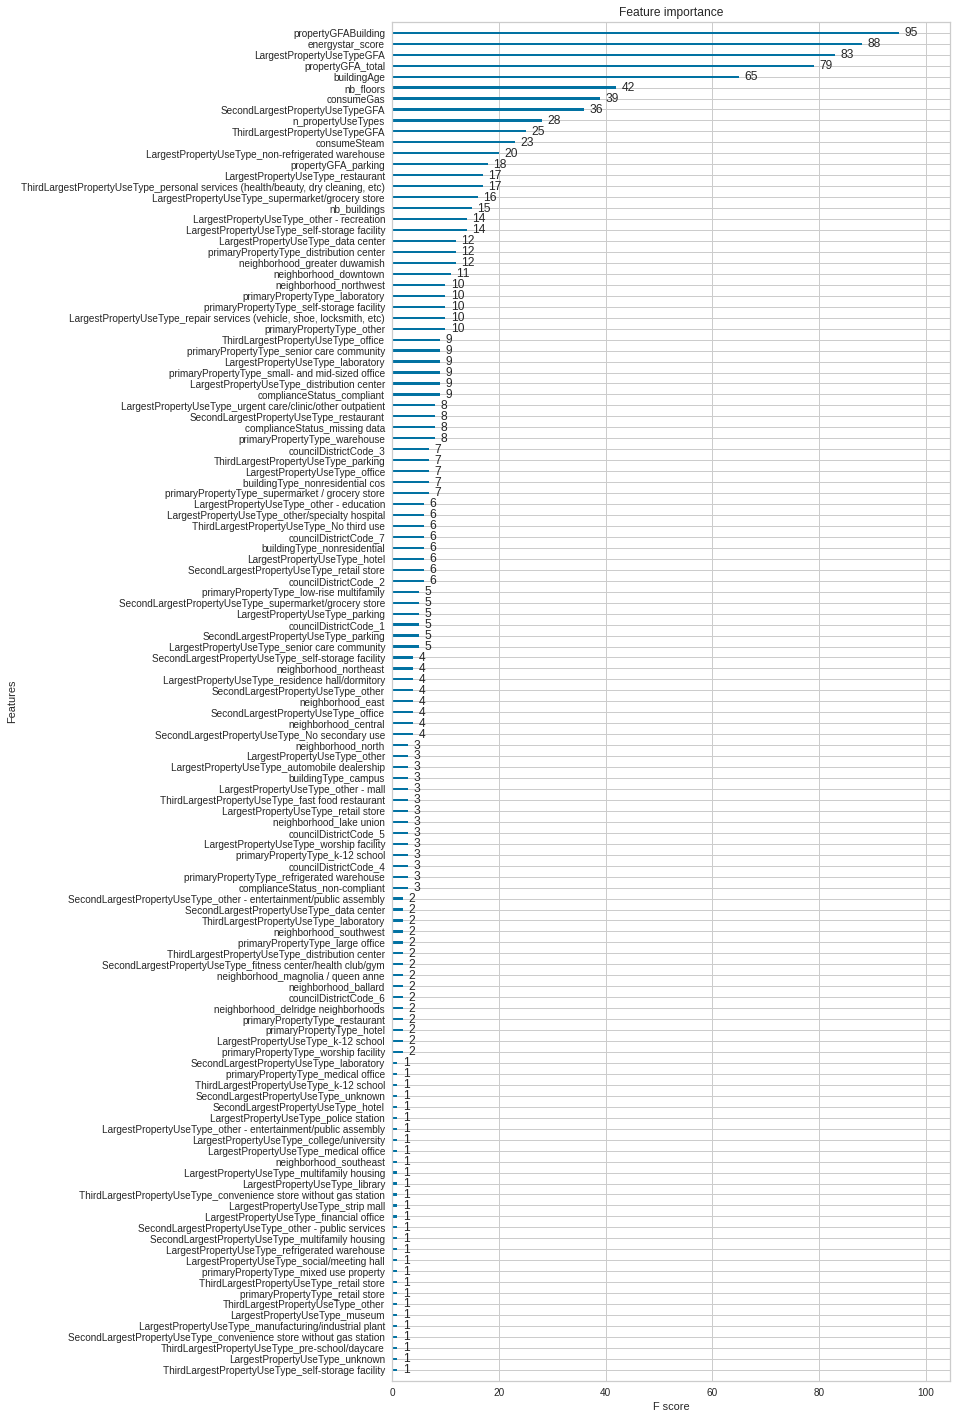

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10, 25))
plot_importance(tuned_model_co2, ax=ax)

**Energy Consumption**

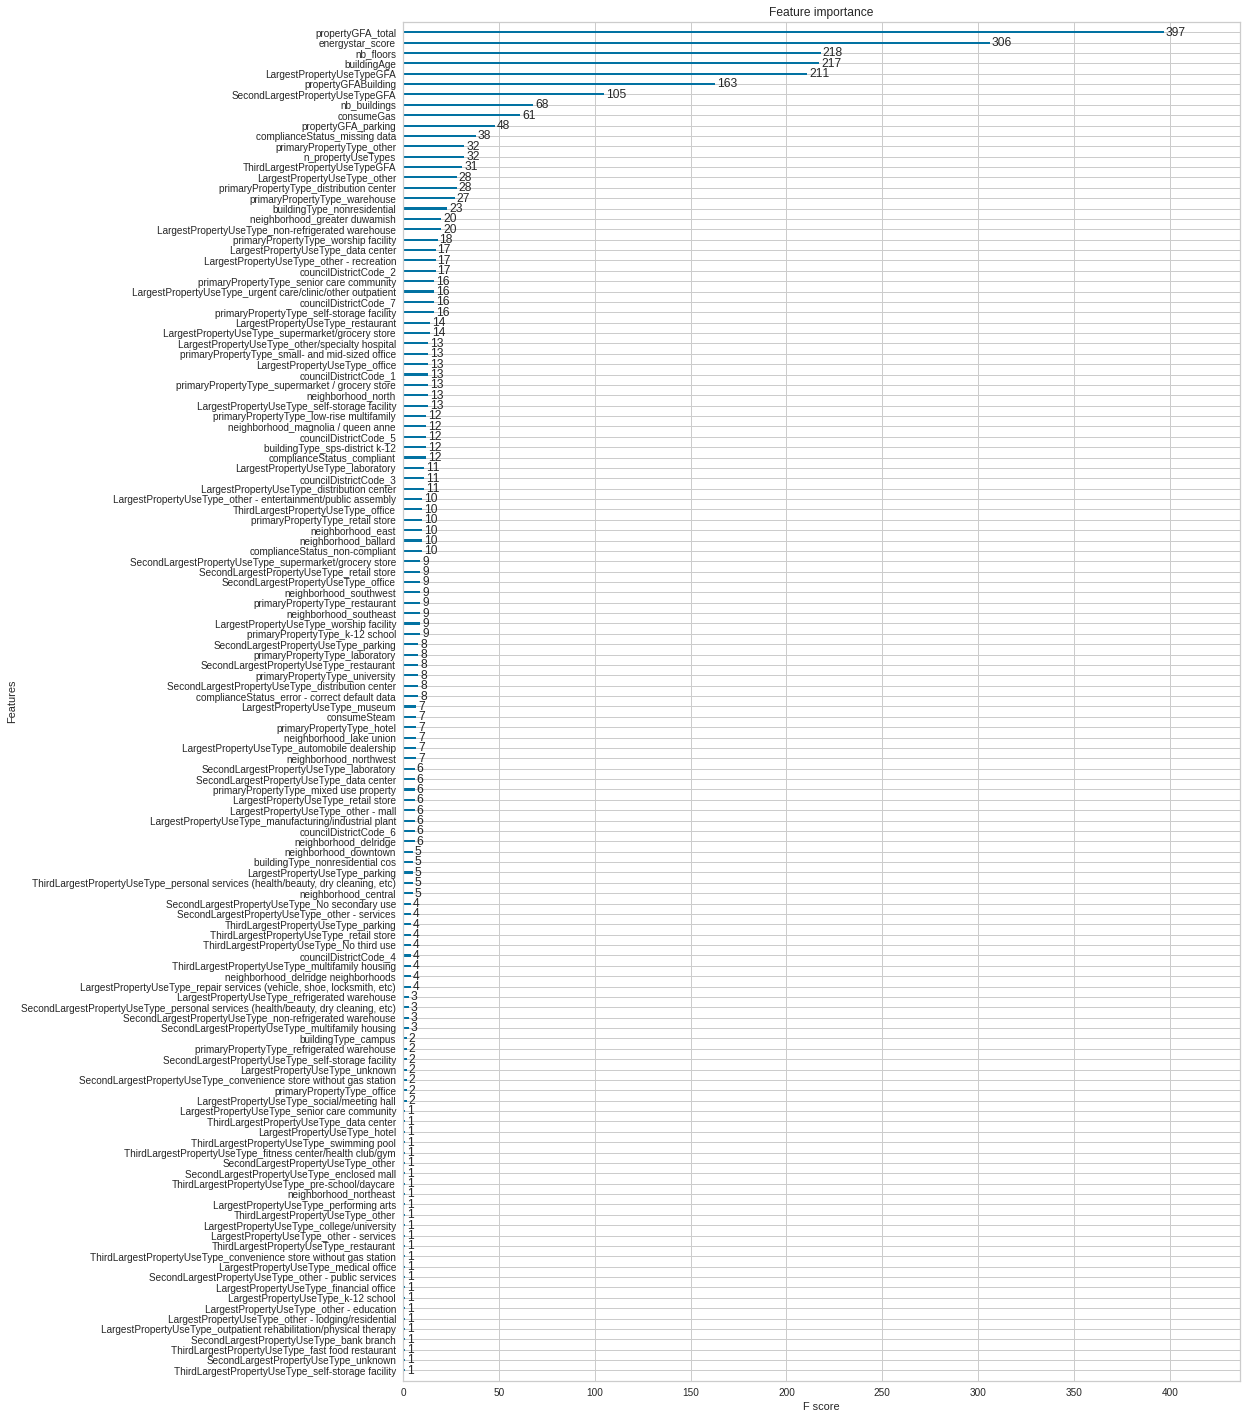

In [ ]:
fig, ax = plt.subplots(figsize=(15, 25))
plot_importance(tuned_model_nrg, ax=ax)
plt.show()

### Random Forest

In [ ]:
def rdm_forest_feature_importance(model, title_prefix):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(15, 40))
    plt.title(title_prefix + ' Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    return indices

**CO2 Emission**

In [ ]:
rf_co2 = RandomForestRegressor(n_jobs=-1, random_state=0)
rf_co2.fit(X_train, y_train_co2)
ordered_indices_co2 = rdm_forest_feature_importance(rf_co2, 'CO2')

**Energy Consumption**

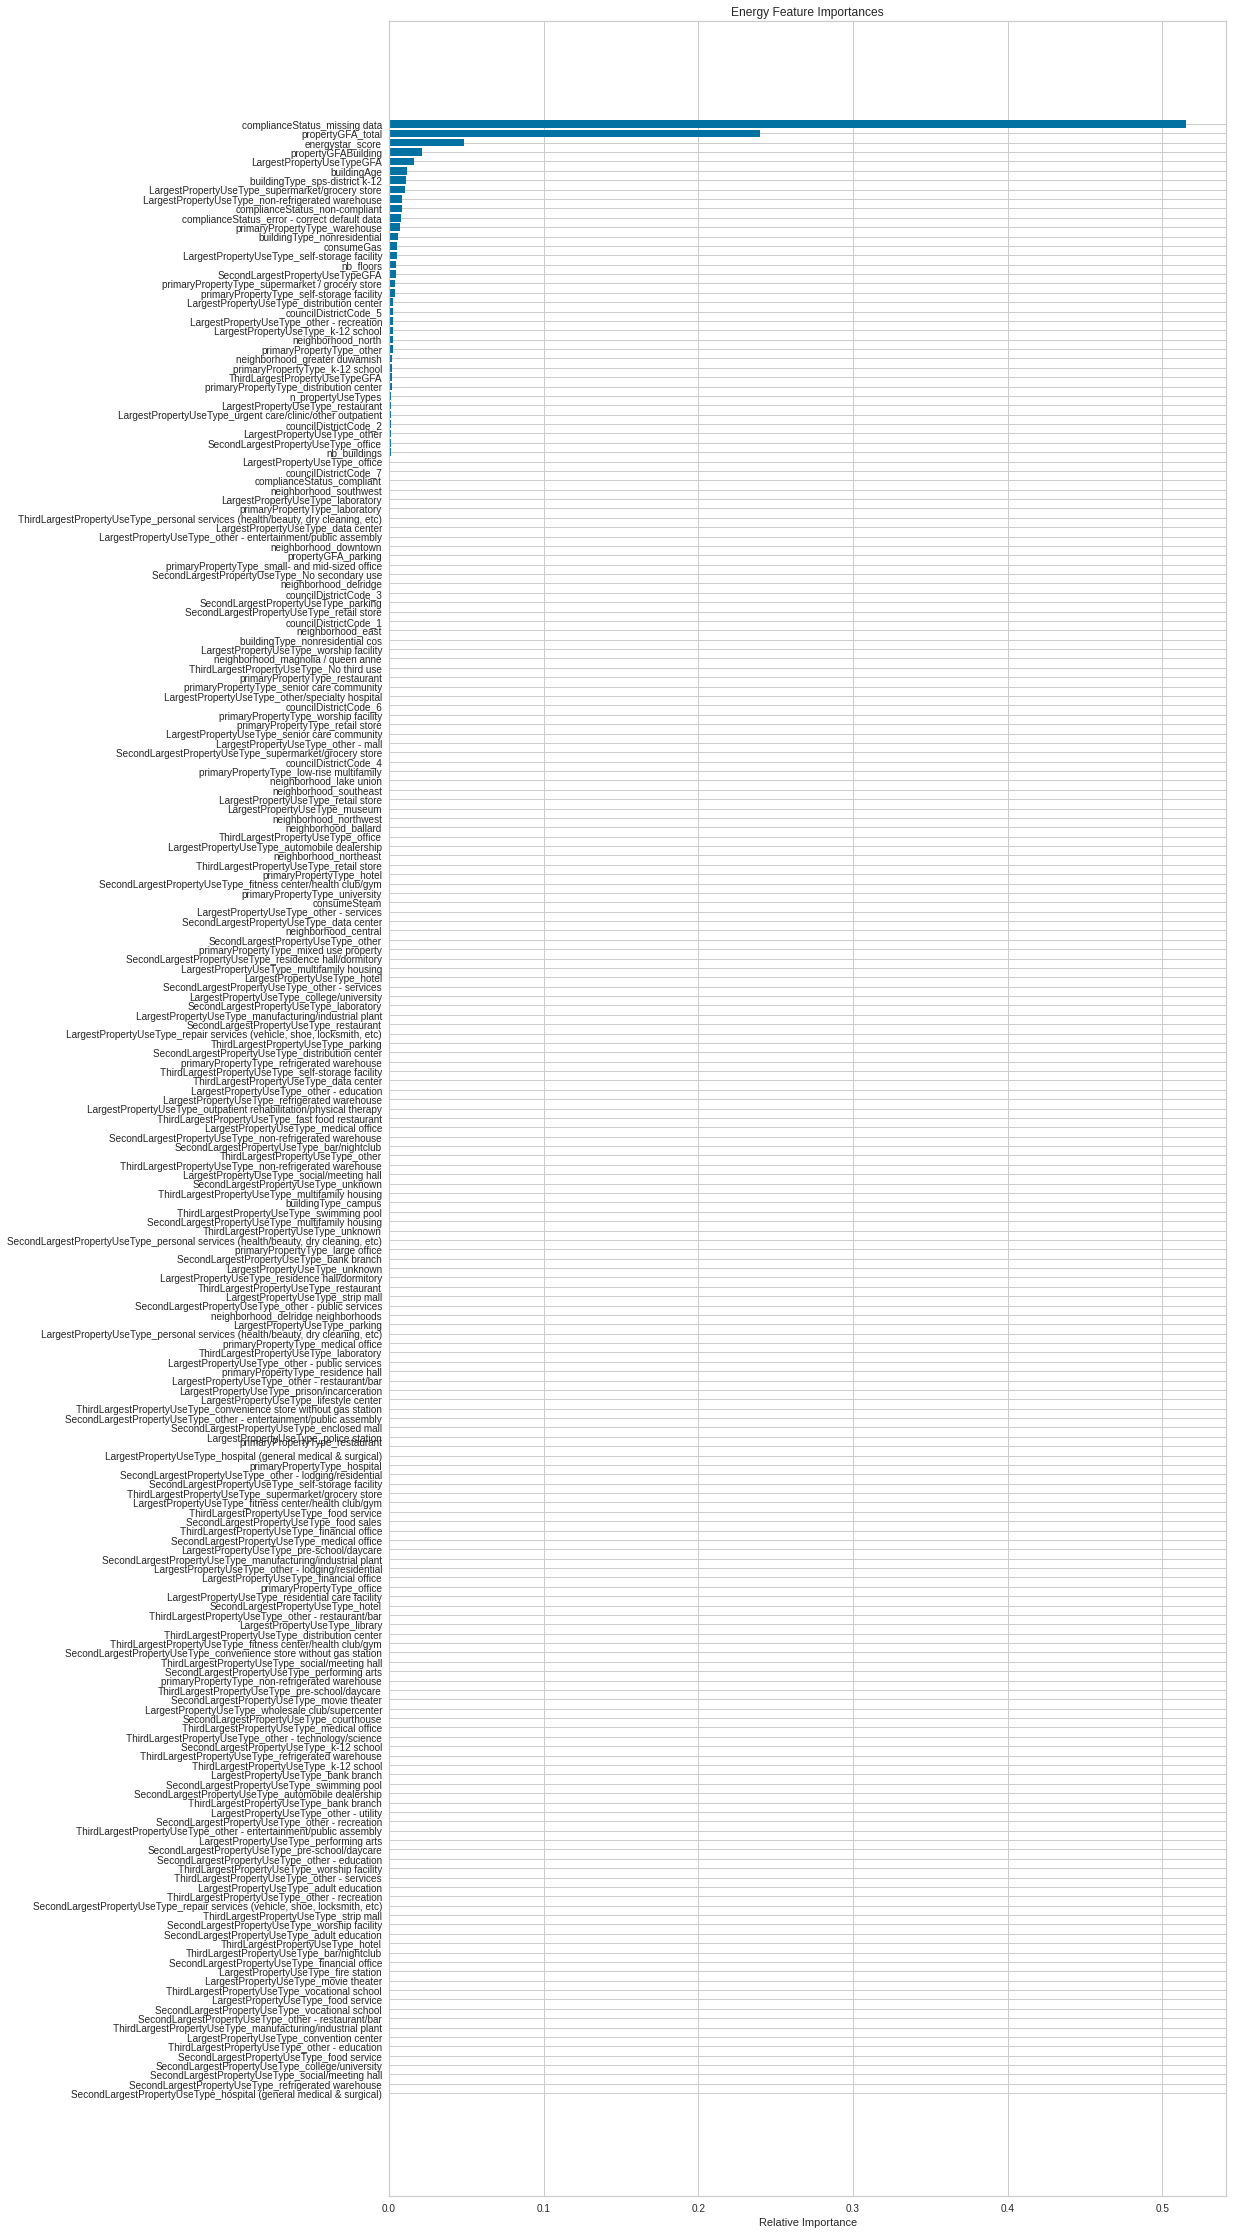

In [ ]:
rf_nrg = RandomForestRegressor(n_jobs=-1, random_state=0)
rf_nrg.fit(X_train, y_train_nrg)
rdered_indices_nrg = rdm_forest_feature_importance(rf_nrg, 'Energy')

## Predictions

In [ ]:
from sklearn import metrics

y_preds_co2 = tuned_model_co2.predict(X_test)
score_co2 = metrics.r2_score(y_test_co2, y_preds_co2)
print(f"CO2 - score on test set : R²={score_co2:.3f}")
# gs_co2.best_score_ / score_co2

y_preds_nrg = tuned_model_nrg.predict(X_test)
score_nrg = metrics.r2_score(y_test_nrg, y_preds_nrg)
print(f"Energy - score on test set : R²={score_nrg:.3f}")
#gs_nrg.best_score_ / score_nrg

CO2 - score on test set : R²=0.713
Energy - score on test set : R²=0.738


In [ ]:
fig = go.Figure([
    go.Bar(x=['CO2', 'Energy'], y=[gs_co2.best_score_, gs_nrg.best_score_], text=[f"{gs_co2.best_score_:.2f}", f"{ gs_nrg.best_score_:.2f}"], marker_color=train_clr, name='Train'),
    go.Bar(x=['CO2', 'Energy'], y=[score_co2, score_nrg], text=[f"{score_co2:.2f}", f"{score_nrg:.2f}"], marker_color=test_clr, name='Test')
])
fig.update_layout(width=700, height=500,
                  title="Tuned XGB comparison",
                  yaxis_title="R²", **plotly_base_params)
fig.show()

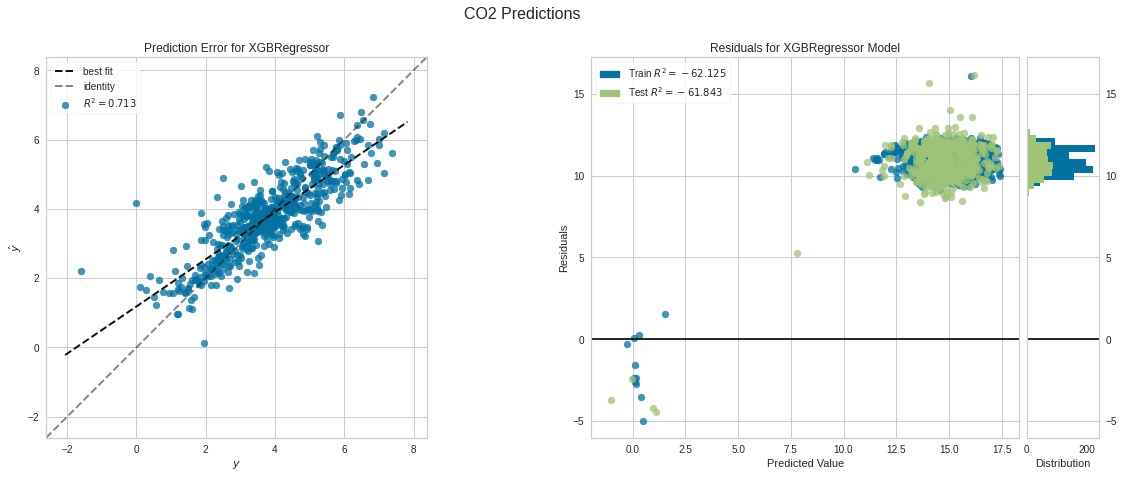

In [ ]:
from yellowbrick.regressor import PredictionError, ResidualsPlot

fig, axes = plt.subplots(1, 2, figsize=(20,7))
visualgrid = [
    PredictionError(tuned_model_co2, ax=axes[0]),
    ResidualsPlot(tuned_model_nrg, ax=axes[1])
]
for viz in visualgrid:
    viz.fit(X_train, y_train_co2)
    viz.score(X_test, y_test_co2)
    viz.finalize()
fig.suptitle('CO2 Predictions', fontsize=16)
plt.show()

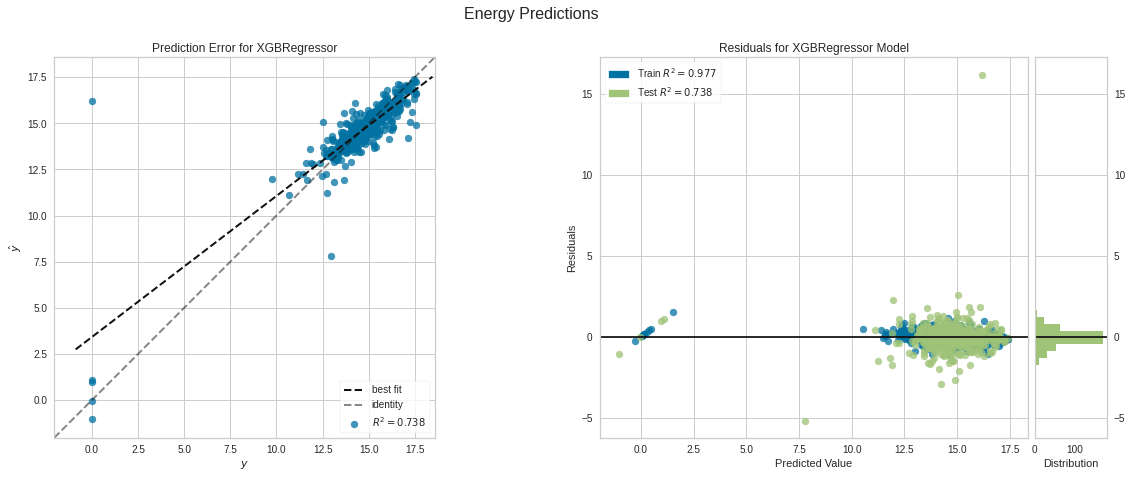

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
visualgrid = [
    PredictionError(tuned_model_nrg, ax=axes[0]),
    ResidualsPlot(tuned_model_nrg, ax=axes[1])
]
for viz in visualgrid:
    viz.fit(X_train, y_train_nrg)
    viz.score(X_test, y_test_nrg)
    viz.finalize()
fig.suptitle('Energy Predictions', fontsize=16)
plt.show()

### predictions by building type

In [ ]:
# Breaks down the test df according to the building types
sliced_df_test_list = {}
buildingType_cols = [col for col in train.columns if 'buildingType' in col]
for buildtype in buildingType_cols:
    partial_df = train[train[buildtype]!=0.]
    if partial_df.shape[0] != 0:
        # this test is used because buildingType_-2 contains no rows
        sliced_df_test_list[buildtype] = partial_df
        print(buildtype, sliced_df_test_list[buildtype].shape[0])

buildingType_campus 11
buildingType_nonresidential 966
buildingType_nonresidential cos 53
buildingType_sps-district k-12 70


In [ ]:
y_pred_scores_co2_per_bt = {}
y_pred_scores_nrg_per_bt = {}
for partial_df_test in sliced_df_test_list:
    print(partial_df_test)
    # separate X/y in each partial test df 
    partial_y_test_co2 = sliced_df_test_list[partial_df_test].GHG_emissions_TCO2e
    partial_y_test_nrg = sliced_df_test_list[partial_df_test].siteEnergyUse_kBtu
    partial_X_test = sliced_df_test_list[partial_df_test].drop(columns=['siteEnergyUse_kBtu', 'GHG_emissions_TCO2e'])
    # then make prediction for each feature to predict
    y_preds_co2 = tuned_model_co2.predict(partial_X_test)
    y_pred_scores_co2_per_bt[partial_df_test] = metrics.r2_score(partial_y_test_co2, y_preds_co2)
    print(f"  > CO2 - R²={y_pred_scores_co2_per_bt[partial_df_test]:.3f}")
    y_preds_nrg = tuned_model_nrg.predict(partial_X_test)
    y_pred_scores_nrg_per_bt[partial_df_test] = metrics.r2_score(partial_y_test_nrg, y_preds_nrg)
    print(f"  > Energy - R²={y_pred_scores_nrg_per_bt[partial_df_test]:.3f}\n")

buildingType_campus
  > CO2 - R²=0.160
  > Energy - R²=0.854

buildingType_nonresidential
  > CO2 - R²=0.800
  > Energy - R²=0.883

buildingType_nonresidential cos
  > CO2 - R²=0.812
  > Energy - R²=0.836

buildingType_sps-district k-12
  > CO2 - R²=0.726
  > Energy - R²=0.991



In [ ]:
fig = go.Figure([
    go.Bar(x=list(y_pred_scores_co2_per_bt.keys()),
           y=list(y_pred_scores_co2_per_bt.values()),
           text=[f"{x:.2f}"for x in y_pred_scores_co2_per_bt.values()],
           marker_color='#B6DEDD', name='CO2'),
    go.Bar(x=list(y_pred_scores_nrg_per_bt.keys()),
           y=list(y_pred_scores_nrg_per_bt.values()),
           text=[f"{x:.2f}"for x in y_pred_scores_nrg_per_bt.values()],
           marker_color='#FFE072', name='Energy')
])
fig.update_layout(width=700, height=500,
                  title="R² on testset by Building Type",
                  yaxis_title="R²", **plotly_base_params)
fig.show()